# Ajuste de modelos via cuadrados mínimos usando PyTorch

## Ejercicio 2)

**1)** Importe librerias `numpy`, `scipy` y `matplotlib`.

**2)** Importe librerias de `pytorch`.
Para ello, vea el colab `pytorch-tutorial-1-tensores.ipynb`.

In [82]:
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [83]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torchviz import make_dot
import torch.optim as optim

## Ejercicio 3)

Considere una secuencia de mediciones $(x_i,y_i)$ con $i=1,...,m$ de una variable independiente $x$ y una variable dependiente $y$.

Considere un modelo

$$
y = f(x,w) = \exp(-w_0 x)\sin(w_1x)
$$

donde $w=(w_0,w_1)$ es el vector de los parámetros del modelo.

**1)** Use `np.linspace` para generar un vector de 20 valores de $x$ en $[0,3]$.

**2)** Con $w=(0.5,4)$, use los valores de $x$ para generar un vector de 30 valores de $y$, i.e. un vector de componentes $y_i = f(x_i,w)$.

**3)** Genere valores experimentales *sintéticos* agregando ruido al vector $y$ generado en **2)**, agregandole números aleatorios obtenidos de una distribución normal de media $0$ y desviación estandard $0.1$.

**4)** Grafique los datos *experimentales* usando puntos.
Simultaneamente, grafique la curva *exacta*, interpolando sobre 300 puntos en el mismo rango.

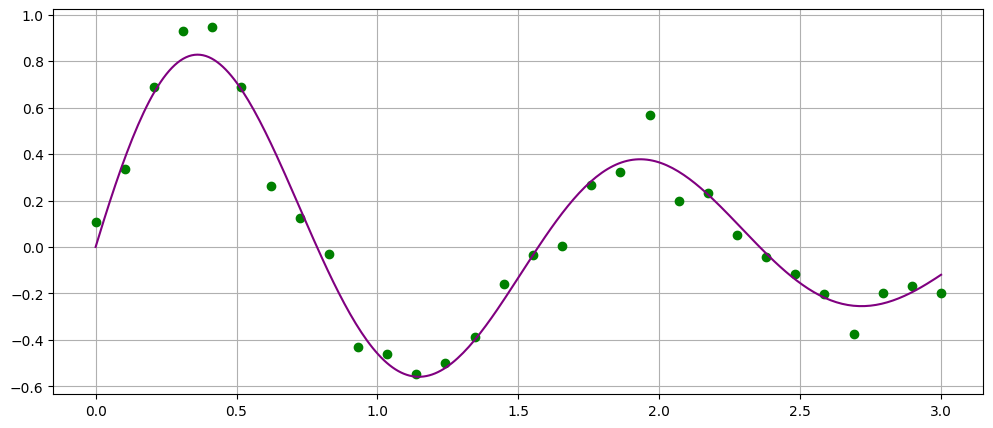

In [84]:
# 3.1)

f = lambda x, w: np.exp(-w[0] * x) * np.sin(w[1] * x)

w = np.array([0.5,4])

xs = np.linspace(0,3,30)
xss = np.linspace(0,3,300)

vals = [f(x,w) + np.random.normal(0,0.1) for x in xs]

exact_curve = [f(x,w) for x in xss]

fig, ax = plt.subplots(1,1, figsize=(12,5))

ax.plot(xs, vals, 'o', color='green')
ax.plot(xss, exact_curve, color='purple')

ax.grid()
plt.show()


## Ejercicio 4)

El ajuste de un modelo por cuadrados mínimos, consiste en encontrar el vector de parámetros que minimiza la suma de los cuadrados de las diferencias entre los datos y las predicciones del modelo.
Más precisamente, consiste en minimizar

$$
E(w) = \sum_i (f(x_i,w)-y_i)^2
$$

con respecto a $w$.

**1)** Minimice $E(w)$ utilizando el algoritmo del descenso por el gradiente.
Implemente el algoritmo utilizando `pytorch`. Saque ventaja de la capacidad de `pytorch` de calcular gradientes de manera automática. Utilice un learning rate $\eta=0.001$ y como valores iniciales de $w$, los originales, pero levemente perturbados con un números aleatorios obtenidos de una distribución normal de media $1$ y desviación estandard $0.25$.

**2)** Grafique, utilizando los mismos 300 puntos de antes, la curva ajustada por el algoritmo anterior.

In [85]:
# 4.1)

x_data = torch.tensor(xs, dtype=torch.float32)  
y_data = torch.tensor(vals, dtype=torch.float32)  

w = torch.tensor([0.5 + np.random.normal(1,0.25), 4 + np.random.normal(1,0.25)], requires_grad=True)

def mse_loss(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean()

optimizer = torch.optim.SGD([w], lr=0.001)

num_epochs = 100000

f_torch = lambda x, w: torch.exp(-w[0] * x) * torch.sin(w[1] * x)

for epoch in range(num_epochs):
    # Predicción
    y_pred = f_torch(x_data, w)
    
    # Calcula la pérdida
    loss = mse_loss(y_pred, y_data)
    
    # Retropropagación
    loss.backward()
    
    # Optimización
    optimizer.step()
    
    # Limpiar gradientes para la siguiente iteración
    optimizer.zero_grad()
    
    if epoch % 10000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, w: {w.data}')

print("Parámetros optimizados:", w.data)

Epoch 0, Loss: 0.08323420584201813, w: tensor([1.6973, 4.9394])
Epoch 10000, Loss: 0.06373647600412369, w: tensor([1.4704, 4.5634])
Epoch 20000, Loss: 0.035288166254758835, w: tensor([1.0624, 4.2254])
Epoch 30000, Loss: 0.008351871743798256, w: tensor([0.5911, 4.0329])
Epoch 40000, Loss: 0.006895364262163639, w: tensor([0.5024, 4.0112])
Epoch 50000, Loss: 0.0068942466750741005, w: tensor([0.5000, 4.0112])
Epoch 60000, Loss: 0.0068942466750741005, w: tensor([0.5000, 4.0112])
Epoch 70000, Loss: 0.0068942466750741005, w: tensor([0.5000, 4.0112])
Epoch 80000, Loss: 0.0068942466750741005, w: tensor([0.5000, 4.0112])
Epoch 90000, Loss: 0.0068942466750741005, w: tensor([0.5000, 4.0112])
Parámetros optimizados: tensor([0.5000, 4.0112])


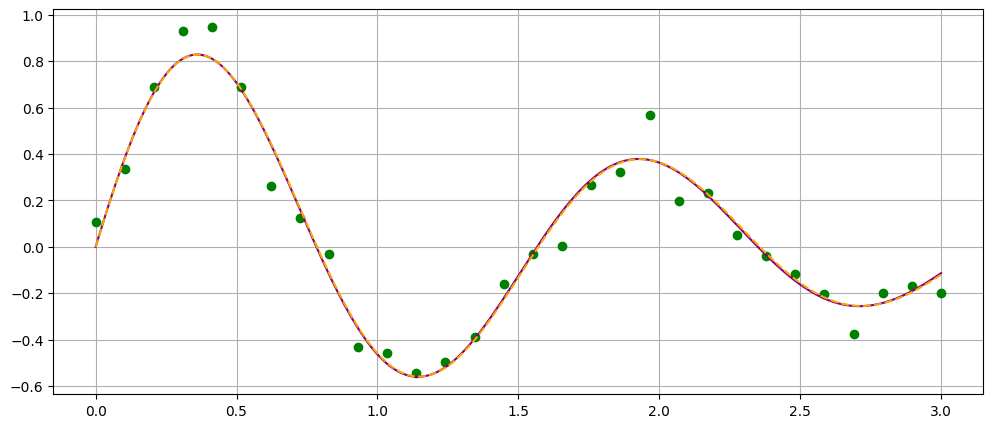

In [ ]:
fited_curve = [f_torch(x,w.data) for x in xss]

fig, ax = plt.subplots(1,1, figsize=(12,5))

ax.plot(xs, vals, 'o', color='green')
ax.plot(xss, fited_curve, color='purple')
ax.plot(xss, exact_curve, '--',color='orange')

ax.grid()
plt.show()


## Ejercicio 5)

**1)** Repita el ejercicio anterior, pero ahora ajustando el modelo

$$
f(x,w) = \exp(-w_0x+w_2)\sin(w_1x+w_3)
$$

i.e. un modelo con dos parámetros ajustables extra.

**2)** Calcule el error cuadratico medio de ambos modelos, sobre los 30 puntos de entrenamiento y sobre los 300 puntos del la curva exacta.

In [87]:
# 5.1)